In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instacart-market-basket-analysis/departments.csv.zip
/kaggle/input/instacart-market-basket-analysis/sample_submission.csv.zip
/kaggle/input/instacart-market-basket-analysis/order_products__train.csv.zip
/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv.zip
/kaggle/input/instacart-market-basket-analysis/orders.csv.zip
/kaggle/input/instacart-market-basket-analysis/products.csv.zip
/kaggle/input/instacart-market-basket-analysis/aisles.csv.zip


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile # zip 파일 풀기

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import os
files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        files.append(filename.split('.zip')[0])
        with zipfile.ZipFile(os.path.join(dirname, filename),"r") as z:
            z.extractall()

In [ ]:
files

['departments.csv',
 'sample_submission.csv',
 'order_products__train.csv',
 'order_products__prior.csv',
 'orders.csv',
 'products.csv',
 'aisles.csv']

In [ ]:
departments = pd.read_csv('./'+files[0], dtype = {'departments_id': np.int32})
order_products_train = pd.read_csv('./'+files[2], dtype = {'order_id' : np.int32, 'product_id' : np.int32,
                                                           'add_to_cart_order' : np.int16, 'reordered' : np.int16})
order_products_prior = pd.read_csv('./'+files[3], dtype = {'order_id' : np.int32, 'product_id' : np.int32,
                                                           'add_to_cart_order' : np.int16, 'reordered' : np.int16})
orders = pd.read_csv('./'+files[4], dtype = {'order_id' : np.int32,'user_id' : np.int32,
                                             'order_number' : np.int16,'order_dow' : np.int16,
                                             'order_hour_of_day' : np.int16})
products = pd.read_csv('./'+files[5],dtype={'products_id': np.int32})
aisles = pd.read_csv('./'+files[6], dtype={'aisles_id': np.int32})

쿼리데이터 만들기

products_detail : products, aisles, department 합친 것

order_prior/train : order_products_prior/train 에 user_id 추가한 것

train/test_users : 학습/테스트 에 사용되는 유저 목록

order_prior_train : train 유저의 과거 주문들

order_prior_train_all : order_prior_train + order_train

order_prior_detail : order_prior + orders by order_id

In [ ]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


**orders.csv**

- 모든 정보들이 담겨있다.
- order_id를 기반으로 무엇을, 구매한 지 몇 일이 지났는지 알 수 있다.
- 날짜 정보와 log 데이터를 통해서 이쯤 이 물건이 필요할 것이라는 것이 예측이 가능해진다.
-

In [ ]:
order_products_prior.head()


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
order_products_train.head()


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


order_products_train 과 order_products_prior의 구조는 같지만 데이터의 내용은 다른 것으로 보와 order_products_prior를 활용하여 현재 살 것 같은 것을 예측하고 추천해주는 것 같습니다.

즉, 재구매할 것 같은 상품 예측입니다.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


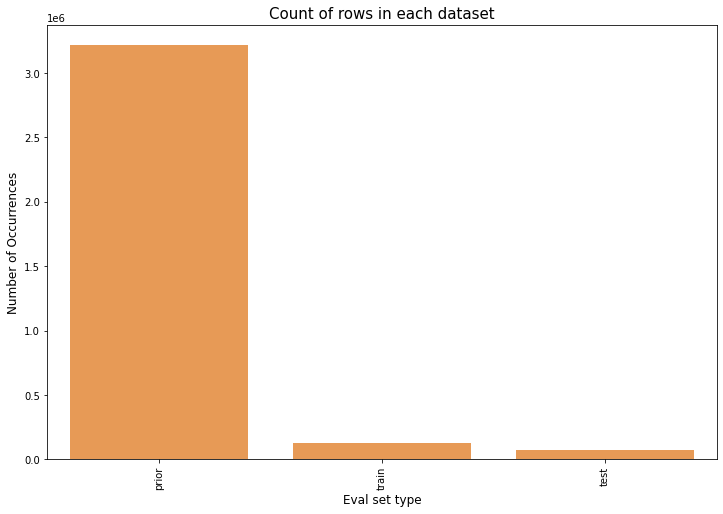

In [ ]:
cnt_srs = orders.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


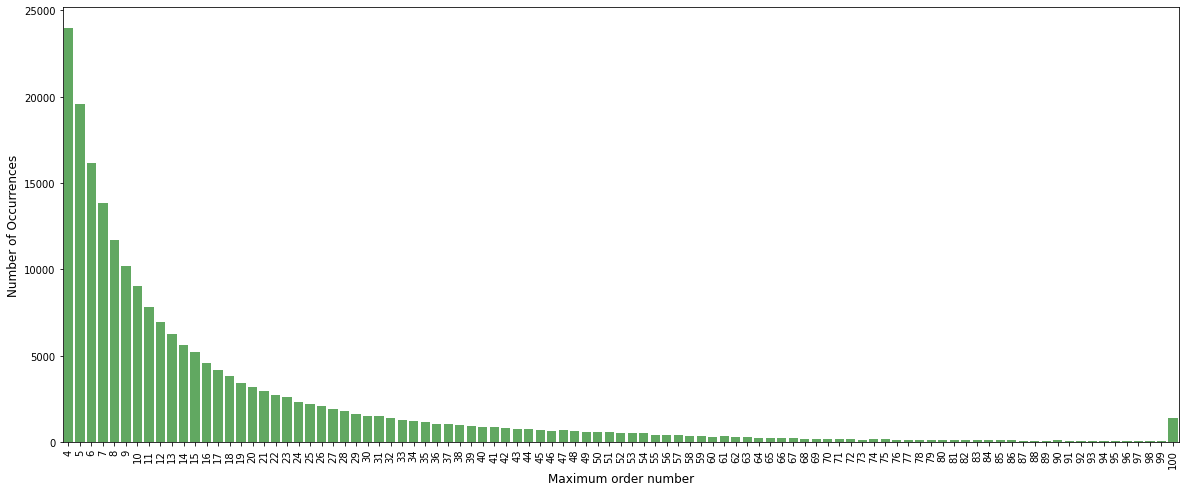

In [ ]:
#유저별로 상품을 구매한 수 
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(20,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

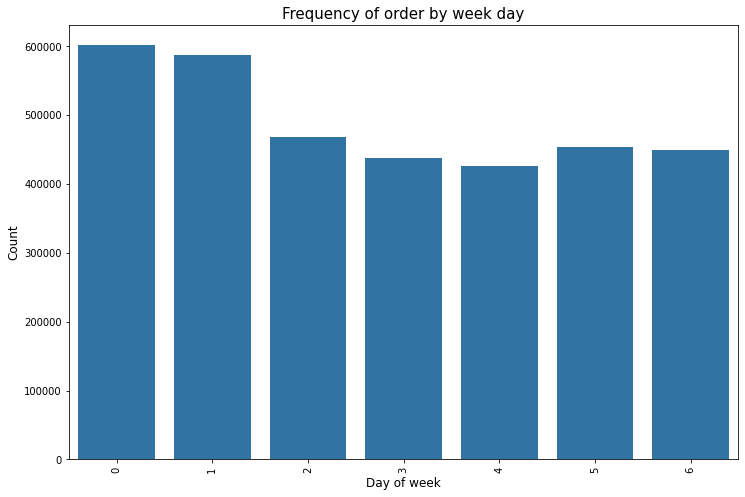

In [ ]:
#토 일 월 화 수 목 금
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

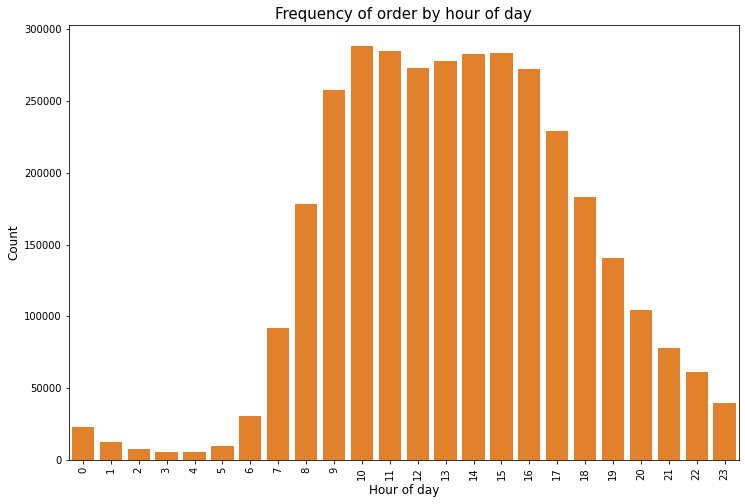

In [ ]:
#하루의 시간
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

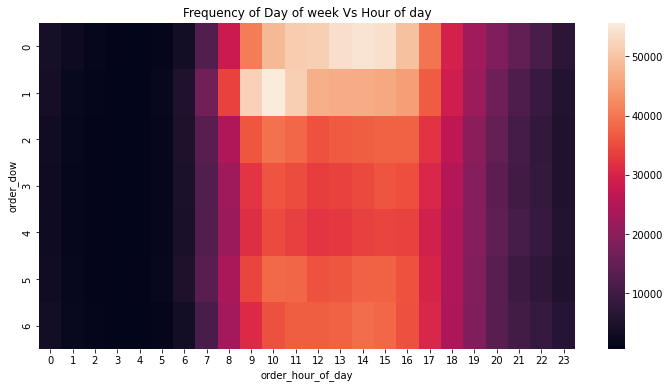

In [ ]:
#시간과 요일을 병합
grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

시간대보단 요일에 영향을 많이 끼친다.
오전은 출근 혹은 달콤한 잠으로 인해서 바쁘기 때문에 구매가 없지만 
그 시간이 지나고부터 퇴근까지는 많다.
생각해보면, 출퇴근 이후에 물건을 사기보단 그 시간에 짬짬히 사고 남들이랑 대화도 하고 그러는 거 같다.(개인적인 경험)

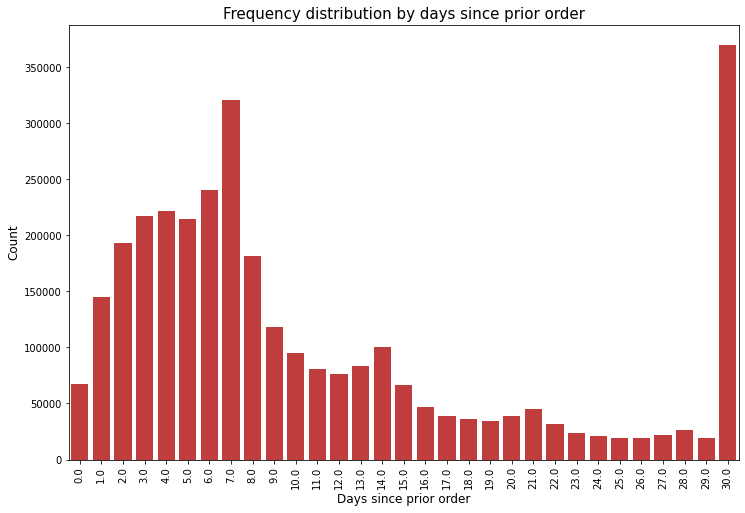

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

1주일 간격 혹은 한 달 간격으로 상품을 구매하는 것처럼 보인다.
그래서, 1주일 간격으로 좌우를 비교하면 7,14,21,28이 높은 것을 알 수 있다.

우리의 목적은 추천시스템이긴 하지만 결국 최종적인 목적은 상품을 (재)구매하도록 유도하는 것이기에 재구매율이 어떻게 되는지도 보겠습니다.

In [ ]:
# percentage of re-orders in prior set #

order_products_prior.reordered.sum() / order_products_prior.shape[0]

0.5896974667922161

In [ ]:
# percentage of re-orders in train set #
order_products_train.reordered.sum() / order_products_train.shape[0]

0.5985944127509629

평균적으로 약 59%의 상품들이 재구매된다. 

다시 말하면, 약 61%정도가 재구매하지 않은 것이다.

In [ ]:
grouped_df = order_products_prior.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].iloc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [ ]:
grouped_df = order_products_train.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].iloc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

과거 데이터에서는 12%로 재구매를 하지 않았지만 훈련 데이터에선 6%정도만 재구매를 하지 않았다.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


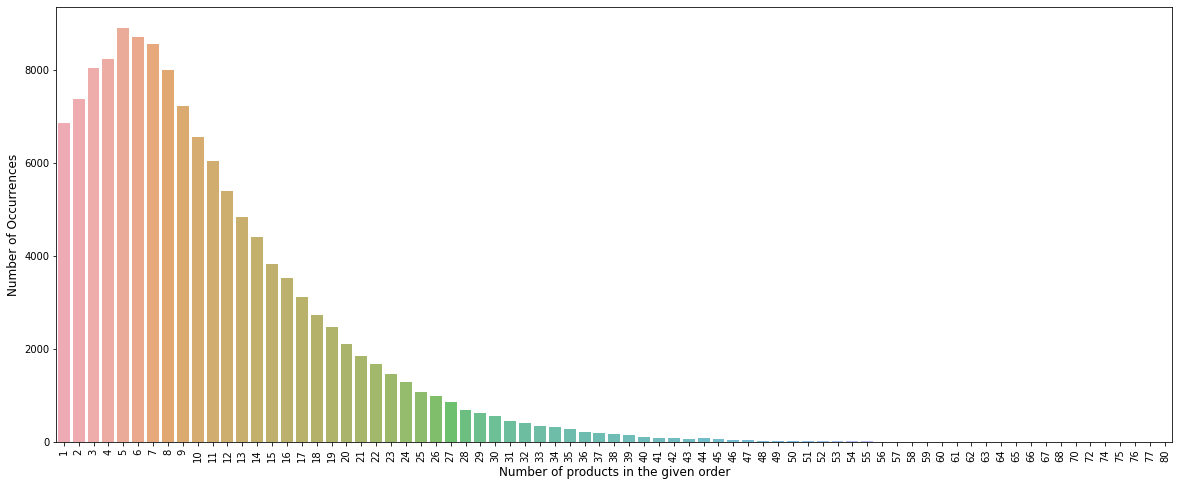

In [ ]:
#each order의 구매된 상품의 수를 보자
grouped_df = order_products_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(20,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

상품 번호는 있지만 무슨 상품인지 모르기에 그걸 알려주는 products 와 aisles 데이터 활용

In [ ]:
products.head()


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
#세부항목
aisles.head()


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
#큰 항목
departments.head()


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


상품의 이름, sub_category, main_category를 활용하면 KNN 혹은 군집 분석이 가능할까?
아니면, 우리가 조건에 의해서 군집 분류를 해볼까?

이 정도의 CATEGORY에 있는 데이터를 몇 개 구매 했다면... 기타 등등으로

예전에 패캠 데이터 분석할 때 조건에 의해서 고객군을 나눈 것처럼


In [ ]:
order_products_prior_df = pd.merge(order_products_prior, products, on='product_id', how='left')


In [ ]:
aisles.columns

Index(['aisle_id', 'aisle'], dtype='object')

In [ ]:
order_products_prior_df = pd.merge(order_products_prior_df, aisles, on='aisle_id', how='left')


상품의 데이터만, 날짜의 데이터만, 수량의 데이터만을 가지고는 할 수 있는게 없지만 이를 합치면 할 수 있는게 있다.

현저히 데이터가 없는 우리는 이것을 밀고 나가야한다.
마켓컬리에서 필요할 데이터,수집을 해야할 데이터를 임의로 설정하고 DB를 구축하여서 데이터를 쌓을 때의 기대효과를 밀고 나가도 괜찮을 것 같다.

이번 데이터에서 날짜는 그대로인데 상품만 마켓컬리를 써서 해도 재미있을 것 같다.

In [ ]:
order_products_prior_df = pd.merge(order_products_prior_df, departments, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


merge를 우리의 상품, 세부항목, 대항목을 이용해서 해봐야겠다.
그러면 이런 식으로 상품을 카운트할 수 있다.

만약 가능하다면, 군집분석, 세부 분석 그리고 로그로 인해서 못할 것 같았던 게 가능해진다.

In [ ]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


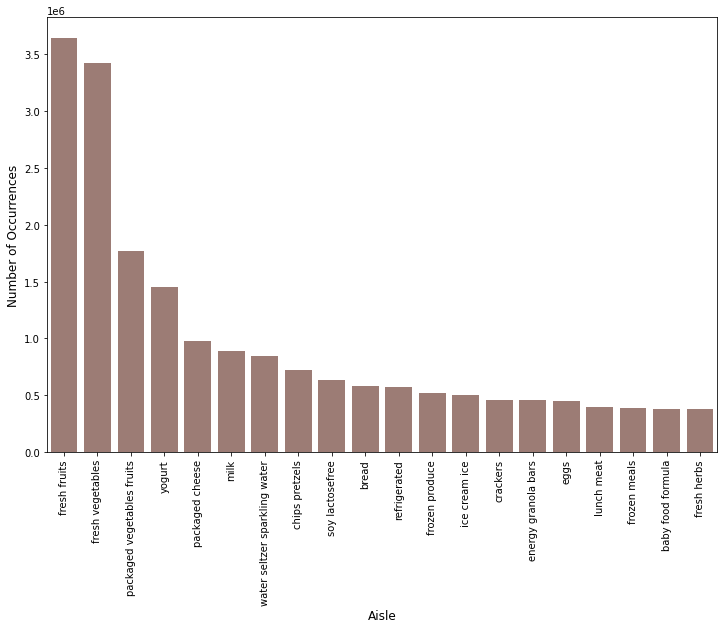

In [ ]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

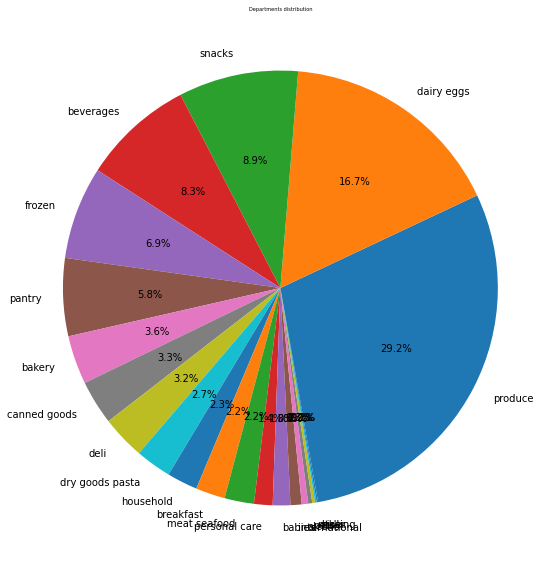

In [ ]:
#department istribution
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=1000)
plt.title("Departments distribution", fontsize=5)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


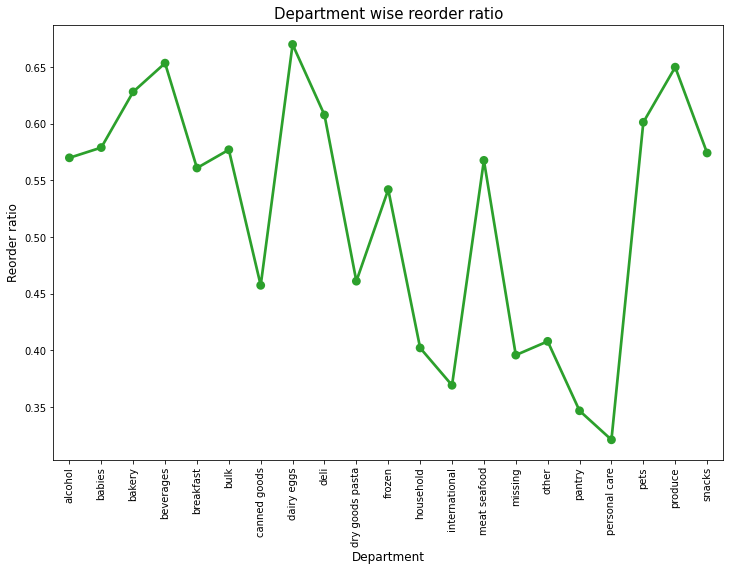

In [ ]:
#Department wise reorder ratio:

grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

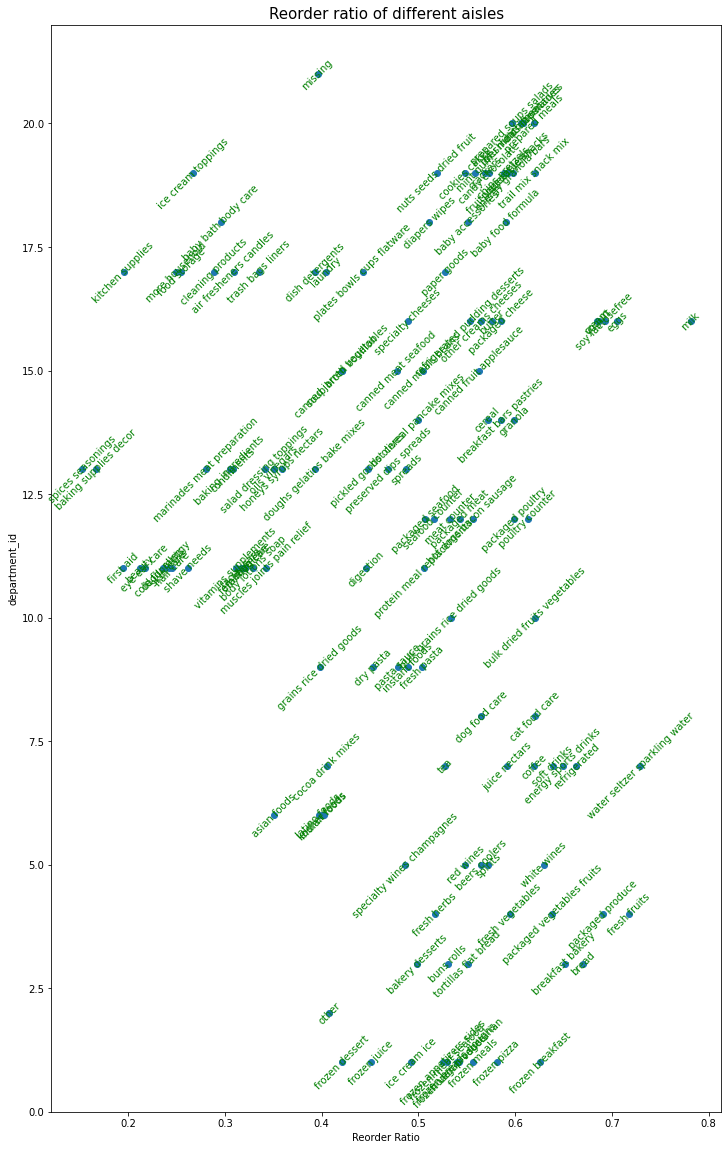

In [ ]:

#Aisle - Reorder ratio:

grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


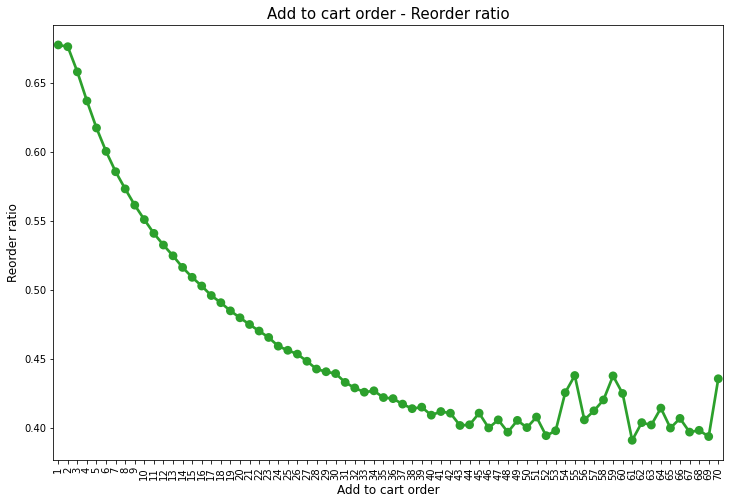

In [ ]:
#Add to Cart - Reorder ratio:

#Let us now explore the relationship between how order of adding the product to the cart affects the reorder ratio.

order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].iloc[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


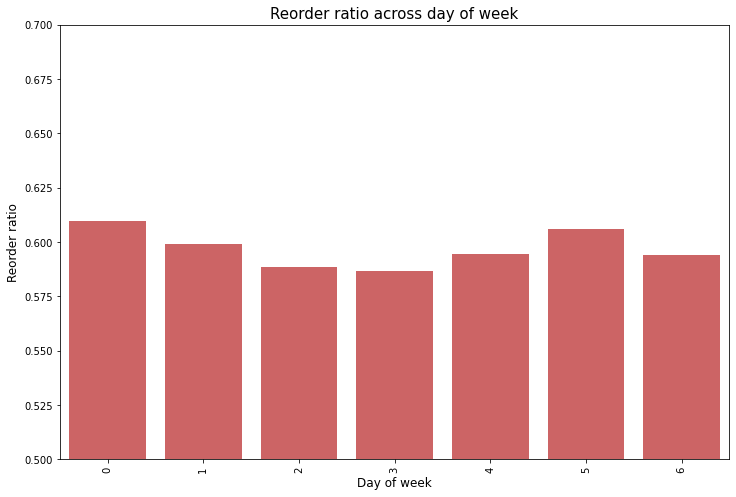

In [ ]:
#Reorder ratio by Time based variables:

order_products_train_df = pd.merge(order_products_train, orders, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


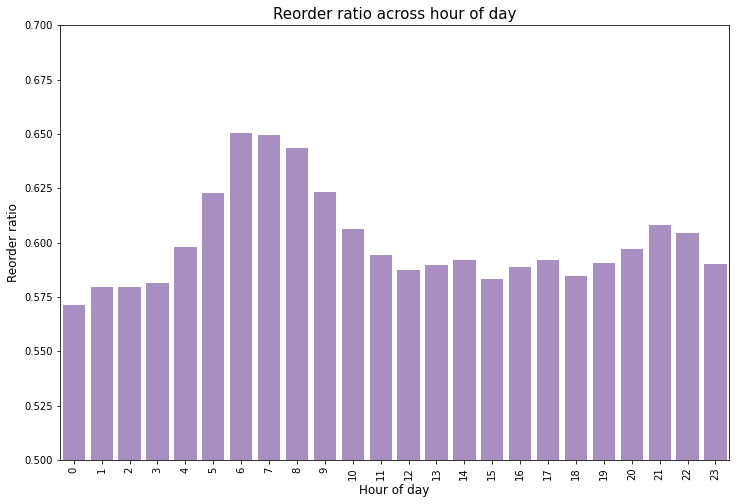

In [ ]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()


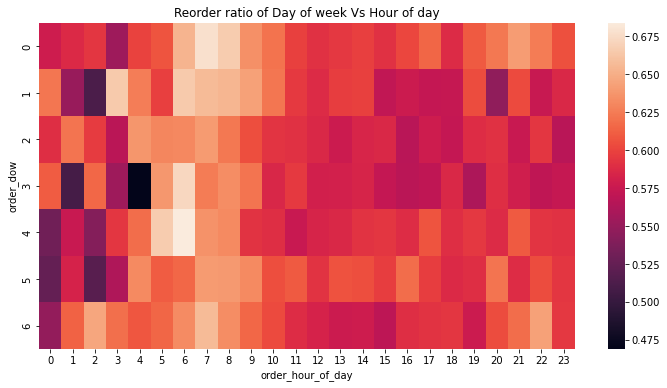

In [ ]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()
